## **Trabalho 2** - Combinação de Fatores para Seleção de Portifólios de Ações

>**Disciplina**: SSC0964

>**Docente**: Denis Fernando Wolf

>**Aluno:** Guilherme Henrique Galdini Tosi

>**N° USP**: 11781587

>**Link do collab**: https://colab.research.google.com/drive/1Uz8PAg6KHmqg483g7uoY2sJcD4ReOFAZ?usp=sharing

##**{SETUP} Definição de termos e reflexões**

>**Quantas ações devo ter na carteira?**

>*Para responder essa pergunta, não há um consenso entre Analistas e Assessores de investimento de um número exato para todas as pessoas. Contudo, com o intuito de alcançar uma diversificação, a ideia é ter ao menos 10 ações de 10 setores diferentes. Já o número máximo vai depender da característica de cada investidor, seus objetivos e prazo de investimento.*

>Fonte: https://blog.toroinvestimentos.com.br/bolsa/quantas-acoes-ter-na-carteira

>**SELIC**: *A SELIC é a taxa básica de juros da economia. É o principal instrumento de política monetária utilizado pelo Banco Central (BC) para controlar a inflação. Ela influencia todas as taxas de juros do país, como as taxas de juros dos empréstimos, dos financiamentos e das aplicações financeiras.* Fonte: https://www.bcb.gov.br/controleinflacao/taxaselic

>**Ibov(IBOVESPA)**: *O Ibovespa significa Índice da Bolsa de Valores de São Paulo. Ele é o principal indicador de desempenho médio das ações listadas. Basicamente, esse índice é uma carteira teórica de ações que contém os ativos que movimentam os maiores volumes de negociação, algo em torno de 80% do total diário. A carteira do Ibovespa é reavaliada a cada quatro meses. Assim, a composição tende a variar ao longo do tempo. Por conta da sua representatividade, o Ibovespa é considerado o benchmark da renda variável. Então, se você quer saber como está o seu desempenho, basta compará-lo ao IBOV.
Caso ele esteja maior ou igual, em termos de valorização, é sinal de que os seus investimentos estão indo bem.* Fonte: https://riconnect.rico.com.vc/blog/ibovespa/

>**IBX**: *O Índice Brasil, também conhecido como IBX, é um índice que mede o retorno de uma carteira hipotética composta por 100 ações selecionadas entre as mais negociadas na BOVESPA, em termos de número de negócios e volume financeiro, ponderadas no índice pelo seu respectivo valor de mercado.*
Fonte: https://www.bussoladoinvestidor.com.br/abc_do_investidor/ibx/

## **{SETUP} Instalação e importação de dependências**

In [679]:
!pip install riskfolio-lib
!pip install prettytable

In [680]:
import numpy as np
import pandas as pd
import riskfolio as rp
import prettytable as pt
import matplotlib.pyplot as plt
from math import sqrt

##**{SETUP}Definição de constantes**

In [681]:
start_date = 13              # correspondente à 01/2005
end_date = start_date + 192  # correspondente à 12/2020
port_steps = 1
eval_steps = 1
index = {'Ibov': 0, 'IBX': 1, 'SELIC': 2}

#dicionário para os dados de mercado:
market_data = {
    'Comp-IBRX': None,   # composição do índice IBX
    'Fechamento': None,  # preços de fechamento dos ativos
    'Base': None,        # índices de referência
}

# Inicialização de dicionário para os dados de fatores:
data_factors = {
    'ROIC': None,     # fator qualidade
    'Momentum': None, # fator momentum
    'Valor-Mercado': None,    # fator tamanho
    'PrecoPatrimonio': None,  # fator PVP
    'Vol': None       # fator volatilidade
}

#prettytable
table = pt.PrettyTable()
table.horizontal_char = '-'
table.vertical_char = '|'
table.junction_char = '+'
table.header_style = 'title'  # Estilo do cabeçalho

## **Passo 0**: Leitura de dados

In [682]:
# Leitura dos dados de mercado dos arquivos:
for key in market_data.keys():
    market_data[key] = pd.read_excel(f'Dados-{key}.xlsx', engine='openpyxl')
    market_data[key].set_index(keys='Data', inplace=True)

columns = len(market_data['Comp-IBRX'].columns)

# Leitura dos dados de fatores dos arquivos:
for key in data_factors.keys():
    data_factors[key] = pd.read_excel(f'Dados-{key}.xlsx', engine='openpyxl')
    data_factors[key].set_index(keys='Data', inplace=True)
    data_factors[key] = data_factors[key].rank(axis=1, numeric_only=True, ascending=False if key in ['ROIC', 'Momentum'] else True, method='first')

# Impressão dos dados de avaliação / rebalanceamento:
print(f'Período de avaliação - de: {market_data["Base"].index[start_date]} ({start_date}) até: {market_data["Base"].index[end_date - 1]} ({end_date - 1})')
print(f'Rebalanceamento a cada 1/1 mes.')

Período de avaliação - de: Jan-2005 (13) até: Dez-2020 (204)
Rebalanceamento a cada 1/1 mes.


## **{SETUP} Definição de Funções Auxiliares**

> Com referência ao material didático utilizado nas aulas teóricas, foram aproveitadas as seguintes funções:

#### **Função para Seleção de Portifólio por Fator**

>Dadaa as informações que descrevem o fator e dada a parcela do ranking(já ordenado de maneira decrescente em relação a qualidade da ação) considerada, a função retorna um dataframe com as ações selecionadas para o portifólio, separando-as por mês.


In [683]:
def sel_1factor_port(original_port, inicio, fim):
    final_port = original_port.copy()
    final_port.loc[:, :] = 0
    for lin in range(start_date, end_date, port_steps):
        for col in range(columns):
            if inicio <= original_port.iat[lin-1, col] <= fim:
                final_port.iat[lin-1, col] = 1
    return final_port

#### **Função para Intersecção de Portifólios**

>Funciona de forma semelhante à primeira função, mas considera a intersecção dos ranking de 2 fatores (n primeiras ações do primeiro + n primeiras ações do segundo) para a formação do portifólio. Retorna um dataframe com as ações selecionadas, separando-as por mês.

In [684]:
def sel_2factors_port(port1, end1, port2, end2):
    final_port = port1.copy()
    final_port.loc[:, :] = 0
    for lin in range(start_date, end_date, port_steps):
        for col in range(columns):
            if 1 <= port1.iat[lin-1, col] <= end1 and 1 <= port2.iat[lin-1, col] <= end2:
                final_port.iat[lin-1, col] = 1
    return final_port

#### **Função para Avaliação de Portifólio**

>Recebe o portifólio, juntamente com os preços de fechamento e retorna dados de interesse sobre o portifólio: retorno acumulado, lista com retornos periódicos, drawdown e retorno e volatilidade anualizados.

In [685]:
def eval_port(port, closures):
    accumulated_ret = [1]
    periodic_return = []
    drawdowns = []
    acc_ret = 1.0
    trans_cost = 0.0006

    for lin in range(start_date, end_date, port_steps):
        actives_counter = 0.0
        actives_profit = 0.0
        for col in range(columns):
            if port.iat[lin-1, col] > 0 and closures.iat[lin-1, col] > 0 and closures.iat[lin-1+port_steps, col] > 0:
                actives_profit += (closures.iat[lin-1+port_steps,col] / closures.iat[lin-1,col]-1) * (port.iat[lin-1, col])
                actives_counter += port.iat[lin-1, col]
        if actives_counter == 0:
             return [1,1], [1,1], [0,0], 0, 0.000001
        acc_ret *= (1.0 + actives_profit / actives_counter - trans_cost)
        periodic_return.append(actives_profit / actives_counter - trans_cost)
        accumulated_ret.append(acc_ret)
        drawdowns.append(acc_ret / np.max(accumulated_ret) - 1)

    anual_ret = pow(acc_ret, 12 / (end_date - start_date)) - 1
    anual_vol = np.std(periodic_return) * (sqrt((12 / port_steps)))

    return {
        'ret_acumulados': accumulated_ret,
        'variacoes': periodic_return,
        'drawdowns': drawdowns,
        'ret_anualizado': anual_ret,
        'vol_anualizada': anual_vol
    }


#### **Função para Avaliação de Referência**

>Recebe a referência a ser considerada e retorna vários dados sobre a mesma: retorno acumulado, retornos periódicos, drawdown e retorno e volatilidade anualizados.

In [686]:
def eval_reference(reference, index):
    accumulated_ret = [1]
    periodic_ret = []
    drawdowns = []
    ret_acc = 1.0

    for lin in range(start_date, end_date, eval_steps):
        profit = reference.iat[lin - 1 + eval_steps, index] / reference.iat[lin - 1, index]
        ret_acc *= profit
        periodic_ret.append(profit-1)
        accumulated_ret.append(ret_acc)
        drawdowns.append(ret_acc / np.max(accumulated_ret) - 1)

    anual_ret = pow(ret_acc, 12 / (end_date - start_date)) - 1
    anual_vol = np.std(periodic_ret) * (sqrt((12 / eval_steps)))

    return {
        'ret_acumulados': accumulated_ret,
        'variacoes': periodic_ret,
        'drawdowns': drawdowns,
        'ret_anualizado': anual_ret,
        'vol_anualizada': anual_vol
    }

#### **Função de otimização da biblioteca riskfolio**

In [687]:
def sel_optimized_port(port, optimization_type, closure):
    months = 24  # p/ volatilidade
    copy_port = port.copy()

    for lin in range(start_date + months, end_date):
        df = pd.DataFrame()
        for col in range(columns):
            if copy_port.iat[lin-1, col] > 0:
                df[copy_port.columns[col]] = closure[copy_port.columns[col]].iloc[lin-1-months:lin-1]
        df.fillna(method='backfill', axis=0, inplace=True)
        df_changes = df.pct_change().dropna()

        if optimization_type == 'RP':  # risk parity
            portifolio_rp = rp.Portfolio(returns=df_changes)
            portifolio_rp.assets_stats(d=0.94, method_cov='hist')
            data_weights = portifolio_rp.rp_optimization(rm='MV', b=None)
        elif optimization_type == 'GMV':  # minimum variance
            portifolio_gmv = rp.Portfolio(returns=df_changes)
            portifolio_gmv.assets_stats(d=0.94)
            data_weights = portifolio_gmv.optimization(model='Classic', rm='MV', obj='MinRisk')
        elif optimization_type == 'MDP':  # maximum decorrelation
            portifolio_mdp = rp.Portfolio(returns=df_changes)
            portifolio_mdp.assets_stats(d=0.94)
            portifolio_mdp.cov = df_changes.corr()
            data_weights = portifolio_mdp.optimization(model='Classic', rm='MV', obj='MinRisk')

        columns_len = len(df_changes.columns)
        for at in range(columns_len):
            copy_port.at[copy_port.index[lin-1], df.columns[at]] = data_weights['weights'].iat[at]

    return copy_port.copy()


####**Função para obtenção dos ativos de um portifolio**

In [688]:
def get_actives_value(port, start_date, end_date, step):
  port_composition = []
  port_len = []

  for lin in range(start_date, end_date, step):
      active_data = []
      for col in range(0, columns):
        if port.iat[lin-1, col] != 0:
          active_data.append(col)
      port_composition.append(active_data)
      port_len.append(len(active_data))

  acoes = list(port.columns.values) #lista de ações

  actives = []
  for i in port_composition[191]: #192 linhas (período: 16anos*12meses = 192)
    acc = []
    for j in range(3, len(acoes[i])):
      acc.append(acoes[i][j])
    acc = ''.join(acc)
    actives.append(acc)
  return actives, port_len

## **Passo 1**: Cálculo da Rentabilidade, Volatilidade e Drawdown de Índices

> Para comparação, foram avaliados os desempenhos da taxa selic e índices Ibovespa e IBX.

In [689]:
data_index = {}

for key in index.keys():
    dados_idc = eval_reference(market_data['Base'], index[key])
    data_index[key] = dados_idc

    #Adiciona os dados à tabela
    table.add_row([
        key,
        round(dados_idc["ret_acumulados"][-1] * 100 - 100, 2),
        round(dados_idc["ret_anualizado"] * 100, 2),
        round(dados_idc["vol_anualizada"] * 100, 2),
        round(dados_idc["ret_anualizado"] / dados_idc["vol_anualizada"], 2),
        round(np.min(dados_idc["drawdowns"]) * 100, 2)
    ])

    # Define os nomes das colunas na tabela
table.field_names = ["Referência", "Retorno Acumulado (%)", "Retorno Anualizado (%)",
                      "Volatilidade Anualizada (%)", "Relação Retorno/Volatilidade", "Drawdown (%)"]


print(table)

+------------+-----------------------+------------------------+-----------------------------+------------------------------+--------------+
| Referência | Retorno Acumulado (%) | Retorno Anualizado (%) | Volatilidade Anualizada (%) | Relação Retorno/Volatilidade | Drawdown (%) |
+------------+-----------------------+------------------------+-----------------------------+------------------------------+--------------+
|    Ibov    |         354.33        |          9.92          |            23.45            |             0.42             |    -49.59    |
|    IBX     |         546.22        |         12.37          |            22.69            |             0.55             |    -49.74    |
|   SELIC    |         397.54        |         10.55          |             1.05            |            10.04             |     0.0      |
+------------+-----------------------+------------------------+-----------------------------+------------------------------+--------------+


## **Passo 1.2**: Avaliação de Portifólios Individuais por fator

> Podemos analisar individualmente cada fator, visando encontrar os de interesse para compor os ativos de um portifólio.

In [690]:
port_data = {}

table.clear()
table.field_names = ["Fator considerado", "Retorno acumulado", "Retorno anualizado",
            "Volatilidade anualizada", "Relação Retorno/Volatilidade",
            "Draw Down", "Alfa", "Beta"]

for key in data_factors.keys():
    port = sel_1factor_port(data_factors[key], 0, 30)
    dados_port = eval_port(port, market_data['Fechamento'])
    port_data[key] = dados_port
    beta, alpha = np.polyfit(data_index['IBX']['variacoes'], dados_port['variacoes'], 1)
    actives, _ = get_actives_value(port, start_date, end_date, 1)

    table.add_row([
        key,
        f'{round(dados_port["ret_acumulados"][-1] * 100 - 100, 2)}%',
        f'{round(dados_port["ret_anualizado"] * 100, 2)}%',
        f'{round(dados_port["vol_anualizada"] * 100, 2)}%',
        round(dados_port["ret_anualizado"] / dados_port["vol_anualizada"], 2),
        f'{round(np.min(dados_port["drawdowns"]) * 100, 2)}%',
        f'{round(alpha * (12 / eval_steps) * 100, 2)}%',
        round(beta, 2)
    ])

print(table)

+-------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
| Fator Considerado | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa | Beta |
+-------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
|        ROIC       |      638.68%      |       13.31%       |          20.75%         |             0.64             |  -48.83%  | 2.93% | 0.83 |
|      Momentum     |      1163.32%     |       17.18%       |          22.17%         |             0.77             |  -46.05%  | 6.33% | 0.85 |
|   Valor-Mercado   |      275.46%      |       8.62%        |          30.7%          |             0.28             |   -73.9%  | -3.2% | 1.14 |
|  PrecoPatrimonio  |      564.57%      |       12.57%       |          29.63%         |             0.42             

### **Passo 1.3**: Análise da rentabilidade

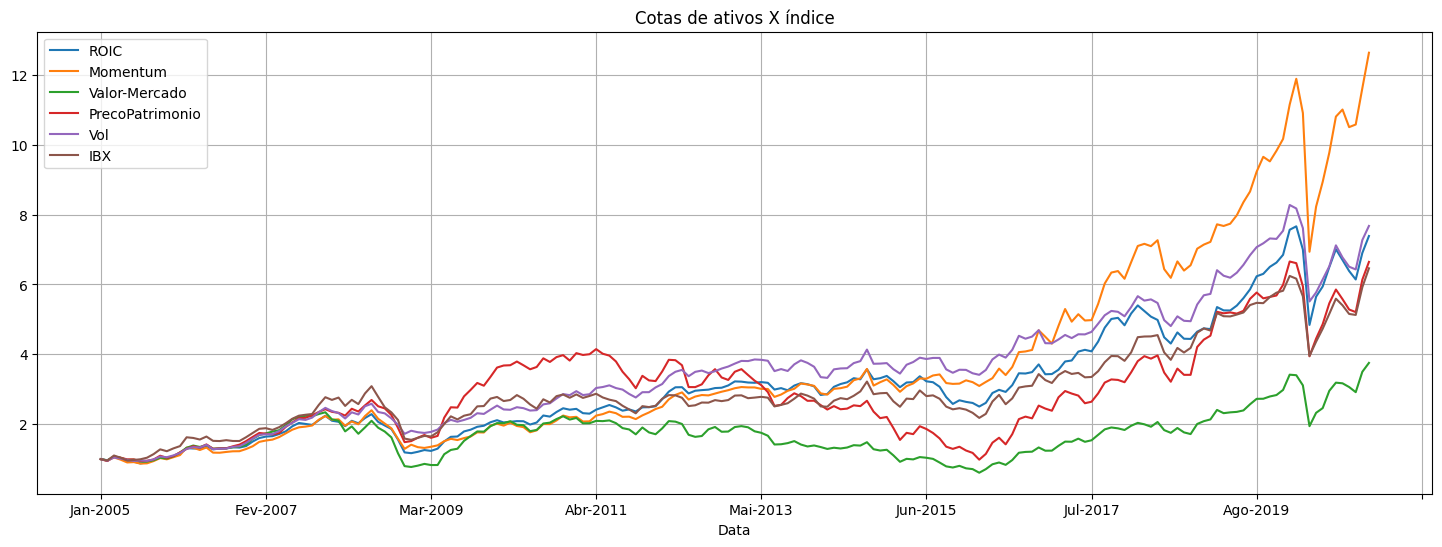

In [691]:
# Evolução das cotas de cada portifólio comparadas com o índice de referência IBX:
df = pd.DataFrame(index=data_factors['ROIC'].iloc[start_date:end_date+1].index)
for chave in data_factors.keys():
    df[chave] = port_data[chave]['ret_acumulados']
df['IBX'] = data_index['IBX']['ret_acumulados']
df.iloc[0:].plot(figsize=(18,6), grid=True, title='Cotas de ativos X índice');

> Como pode-se observar, o ranking de fatores de maior rentabilidade acumulada, considerando as 30 melhores ações de cada fator no período considerado, temos em ordem descrescente:

>* Fator Momentum;
* Fator Volatilidade;
* Fator Qualidade (ROIC - _Return On Invested Capital_);
* Fator Preço (Preço / Valor Patrimonial);
* Fator Tamanho (Valor de Mercado).

### **Passo 1.4**: Análise da volatilidade

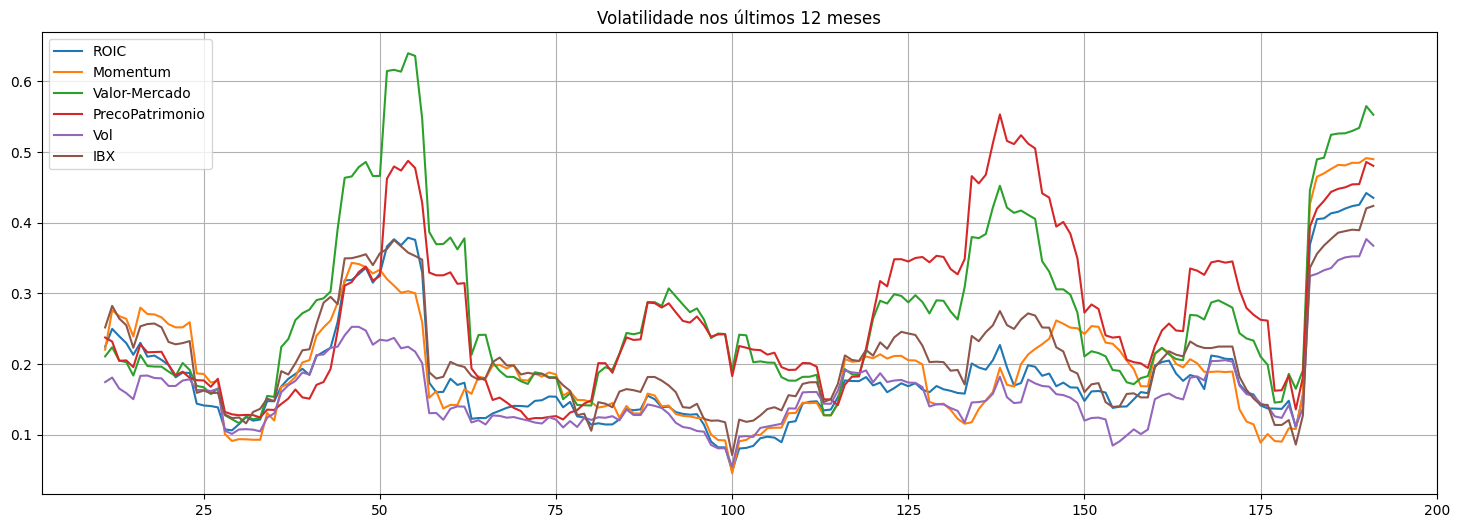

In [692]:
# Evolução da volatilidade dos últimos 12 meses de cada portfólio comparadas com o índice de referência IBX:
df = pd.DataFrame()
for key in data_factors.keys():
    df[key] = pd \
        .Series(port_data[key]['variacoes']) \
        .rolling(int(12 / eval_steps)) \
        .std() * (sqrt(int(12 / eval_steps)))
df['IBX'] = pd \
    .Series(data_index['IBX']['variacoes']) \
    .rolling(int(12/eval_steps)) \
    .std()*(sqrt(int(12/eval_steps)))
df.plot(figsize=(18,6), grid=True, title='Volatilidade nos últimos 12 meses');

>Em relação à menor volatilidade, considerando-se as 30 melhores ações de cada fator, o ranking de fatores, em ordem crescente, é:

>* Fator Volatilidade;
* Fator Qualidade (ROIC);
* Fator Momentum;
* Fator Preço (PVP);
* Fator Tamanho (Valor de Mercado).

## **Passo 2**: Composição dos Portifólios

### **Passo 2.1**: Portifólio com foco em rentabilidade

>Para compor o portifólio com foco em rentabilidade, mais arrojado, podemos considerar a análise anterior, dos 30 melhores ativos e usar os 2 fatores que apresentaram melhor desempenho individual na rentabilidade acumulada: Momentum e Volatilidade.

In [693]:
profit_port = sel_2factors_port(data_factors['Momentum'], 30, data_factors['Vol'], 30)
data_port = eval_port(profit_port, market_data['Fechamento'])
beta, alpha = np.polyfit(data_index['IBX']['variacoes'], data_port['variacoes'], 1)
actives, data_len = get_actives_value(profit_port, start_date, end_date, 1)

table.clear()
table.field_names = ["Fatores Momentum e Volatilidade", "Retorno acumulado", "Retorno anualizado",
                "Volatilidade anualizada", "Relação Retorno/Volatilidade",
                "Draw Down", "Alfa", "Beta"]

table.add_row([
    "Dados",
    f'{round(data_port["ret_acumulados"][-1] * 100 - 100, 2)}%',
    f'{round(data_port["ret_anualizado"] * 100, 2)}%',
    f'{round(data_port["vol_anualizada"] * 100, 2)}%',
    round(data_port["ret_anualizado"] / data_port["vol_anualizada"], 2),
    f'{round(np.min(data_port["drawdowns"]) * 100, 2)}%',
    f'{round(alpha * (12 / eval_steps) * 100, 2)}%',
    round(beta, 2),
])

print(table)

+---------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+
| Fatores Momentum E Volatilidade | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa  | Beta |
+---------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+
|              Dados              |      2422.46%     |       22.35%       |          19.0%          |             1.18             |  -30.97%  | 13.39% | 0.61 |
+---------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+


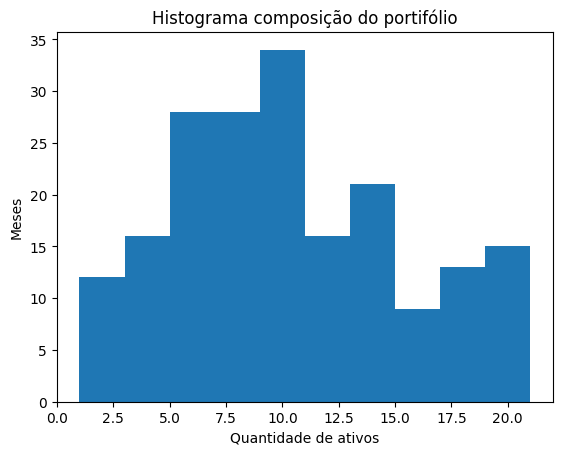

In [694]:
plt.hist(data_len)
plt.title("Histograma composição do portifólio")
plt.xlabel("Quantidade de ativos")
plt.ylabel("Meses")
plt.show()

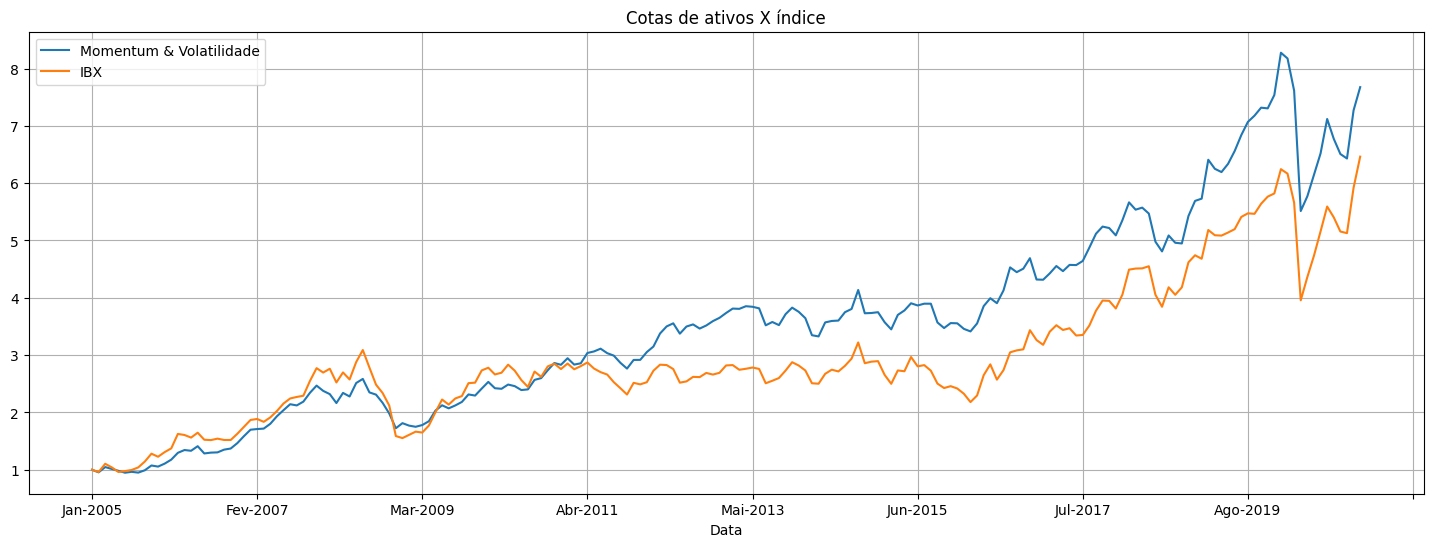

In [695]:
# Evolução das cotas do portifólio não otimizado comparadas com o índice de referência IBX:
df = pd.DataFrame(index=data_factors['ROIC'].iloc[start_date:end_date+1].index)
df['Momentum & Volatilidade'] = dados_port['ret_acumulados']
df['IBX'] = data_index['IBX']['ret_acumulados']
df.iloc[0:].plot(figsize=(18,6), grid=True, title='Cotas de ativos X índice');

>Percebe-se que o retorno acumulado deste portifólio é bem mais expressivo que o retorno acumulado do IBX.

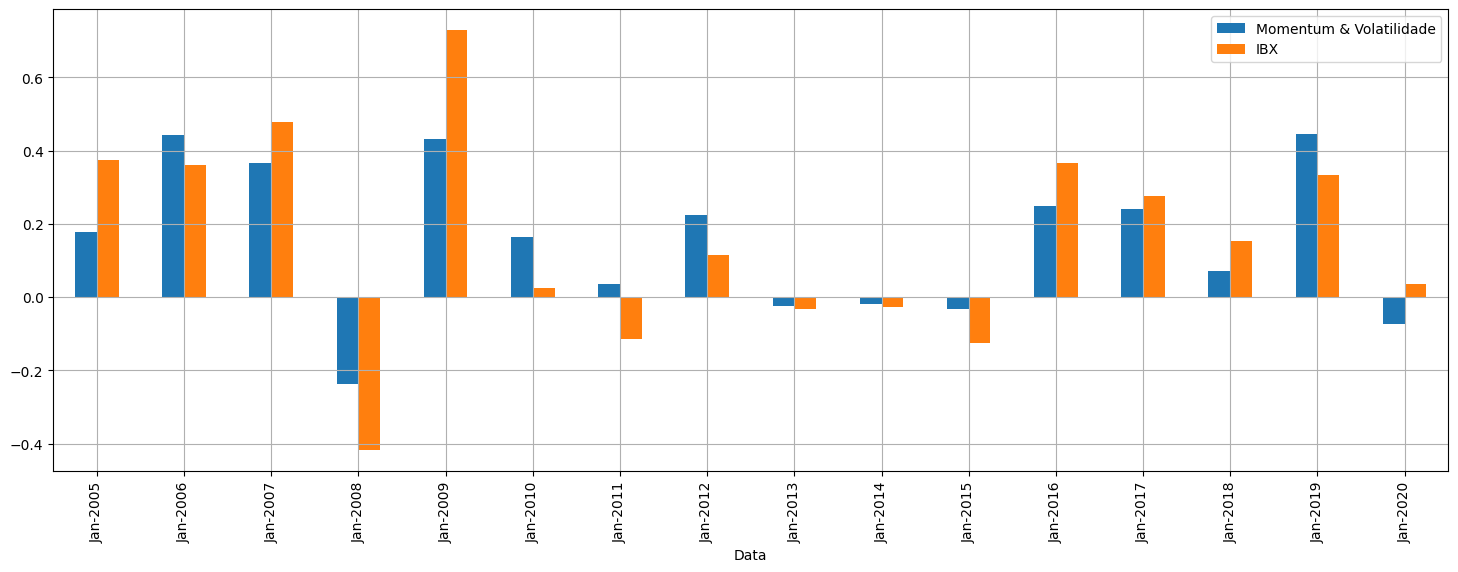

In [696]:
# Retorno anual de um portfólionão otimizado comparado à referência IBX
df2 = pd.DataFrame(columns=['Data', 'Momentum & Volatilidade', 'IBX'])
for ind in range(0, len(df.index) - 12, 12):
    tempo = df.iloc[ind+12] / df.iloc[ind] - 1
    df2 = df2._append(tempo, ignore_index=True)
    df2.iat[len(df2) - 1, 0] = df.index[ind]
df2.set_index(keys='Data', inplace=True)
df2.plot.bar(figsize=(18,6), grid=True);

> Esse poortifólio foi mais rentávem em 9 períodos, considerando períodos de alta e de baixa, isso corresponde a 56.25% do tempo.

##**Passo 2.1.1: Portifólio com foco em rentabilidade com maior volume de ativos**

>Para compor o portifólio com foco em rentabilidade, testaremos também o compoortamento desse portifólio coom maior volume de ativos. Como resultado, vemos que o retorno é inversamente proporcional a quantiidade de ativos, embora traga com ele, uma volatilidade sutilmente menor.

In [697]:
profit_port2 = sel_2factors_port(data_factors['Momentum'], 60, data_factors['Vol'], 60)
data_port2 = eval_port(profit_port2, market_data['Fechamento'])
beta, alpha = np.polyfit(data_index['IBX']['variacoes'], data_port2['variacoes'], 1)
actives, data_len = get_actives_value(profit_port2, start_date, end_date, 1)

table.clear()
table.field_names = ["Fatores Momentum e Volatilidade", "Retorno acumulado", "Retorno anualizado",
                "Volatilidade anualizada", "Relação Retorno/Volatilidade",
                "Draw Down", "Alfa", "Beta"]

table.add_row([
    "Dados",
    f'{round(data_port2["ret_acumulados"][-1] * 100 - 100, 2)}%',
    f'{round(data_port2["ret_anualizado"] * 100, 2)}%',
    f'{round(data_port2["vol_anualizada"] * 100, 2)}%',
    round(data_port2["ret_anualizado"] / data_port2["vol_anualizada"], 2),
    f'{round(np.min(data_port2["drawdowns"]) * 100, 2)}%',
    f'{round(alpha * (12 / eval_steps) * 100, 2)}%',
    round(beta, 2),
])

print(table)

+---------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
| Fatores Momentum E Volatilidade | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa | Beta |
+---------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
|              Dados              |      993.01%      |       16.12%       |          18.78%         |             0.86             |  -39.17%  | 6.01% | 0.76 |
+---------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+


##**Passo 2.1.2: Gráfico do portifólio com foco em rentabilidade com maior volume de ativos**

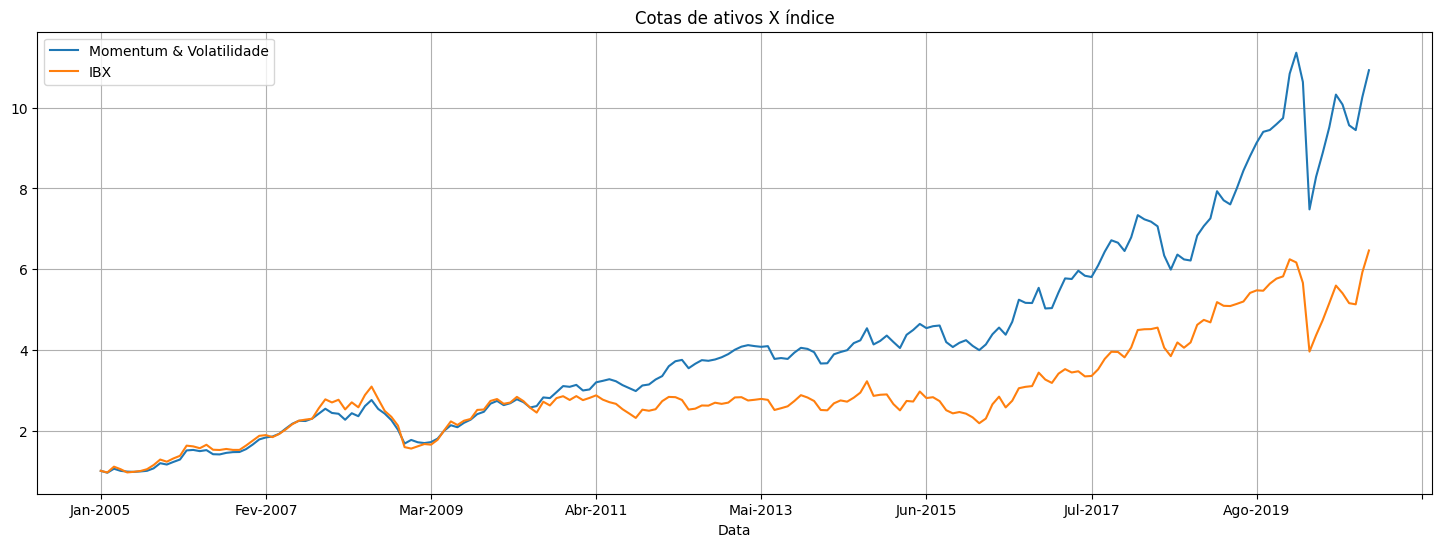

In [698]:
# Evolução das cotas do portifólio não otimizado comparadas com o índice de referência IBX:
df = pd.DataFrame(index=data_factors['ROIC'].iloc[start_date:end_date+1].index)
df['Momentum & Volatilidade'] = data_port2['ret_acumulados']
df['IBX'] = data_index['IBX']['ret_acumulados']
df.iloc[0:].plot(figsize=(18,6), grid=True, title='Cotas de ativos X índice');

> Percebe-se que o retorno acumulado deste portifólio é bem mais expressivo que o retorno acumulado do IBX com o passar do tempo(pelo gráfico, em torno de 2010).

### **Passo 2.2**: Portifólio otimizado com foco em rentabilidade

>É possível, considerando os métodos de otimização da biblioteca riskfolio, distribuir os pesos de alocação:

>- RP: Risk Parity;
- GMV: Minimum Variance;
- MDP: Maximum Decorrelation.

In [699]:
table.clear()
table.field_names = ["Tipo de Otimização", "Retorno Acumulado", "Retorno Anualizado",
                      "Volatilidade Anualizada", "Relação Retorno/Volatilidade",
                      "Draw Down", "Alfa", "Beta"]

for optimization_type in ['RP', 'GMV', 'MDP']:
    portifolio_rent_otimizado = sel_optimized_port(profit_port, optimization_type,  market_data['Fechamento'])
    data_port = eval_port(portifolio_rent_otimizado, market_data['Fechamento'])
    beta, alpha = np.polyfit(data_index['IBX']['variacoes'], data_port['variacoes'], 1)
    active, data_len = get_actives_value(portifolio_rent_otimizado, start_date, end_date, 1)
    table.add_row([
        f'Otimização {optimization_type}',
        f'{round(data_port["ret_acumulados"][-1] * 100 - 100, 2)}%',
        f'{round(data_port["ret_anualizado"] * 100, 2)}%',
        f'{round(data_port["vol_anualizada"] * 100, 2)}%',
        round(data_port["ret_anualizado"] / data_port["vol_anualizada"], 2),
        f'{round(np.min(data_port["drawdowns"]) * 100, 2)}%',
        f'{round(alpha * (12 / eval_steps) * 100, 2)}%',
        round(beta, 2)
    ])

print(table)

+--------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+
| Tipo De Otimização | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa  | Beta |
+--------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+
|   Otimização RP    |      1995.32%     |       20.94%       |          18.66%         |             1.12             |   -33.4%  | 12.61% | 0.58 |
|   Otimização GMV   |      1201.98%     |       17.4%        |          19.1%          |             0.91             |  -33.47%  | 10.37% | 0.53 |
|   Otimização MDP   |      1367.04%     |       18.28%       |          19.05%         |             0.96             |  -33.16%  | 10.83% | 0.55 |
+--------------------+-------------------+--------------------+-------------------------+-----------------

>Percebe-se que com o portifólio otimizado, a rentabilidade acumulada foi reduzida para todos os métodos de otimização. Entretanto os valores de volatilidades anualizadas foram parecidos com os do portifólio original e os valores de draw down foram relativamente piores. A otimização mais adequada para o foco em rentabilidade, nesse caso, é a _RP_, uma vez que tem a maior rentabilidade acumulada.

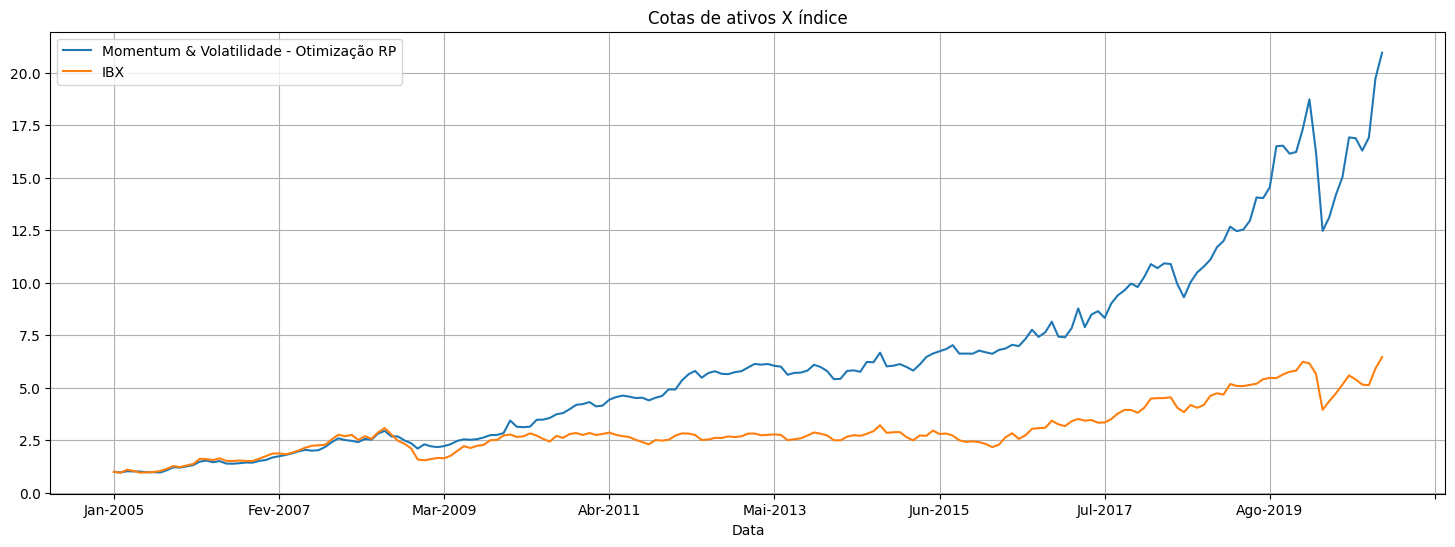

In [700]:
# Otimização RP:
rp_port = sel_optimized_port(profit_port, 'RP', market_data['Fechamento'])
data_port = eval_port(rp_port, market_data['Fechamento'])
actives = get_actives_value(rp_port, start_date, end_date, 1)

# Evolução das cotas do portifólio otimizado comparadas com o índice de referência IBX:
df = pd.DataFrame(index=data_factors['ROIC'].iloc[start_date:end_date+1].index)
df['Momentum & Volatilidade - Otimização RP'] = data_port['ret_acumulados']
df['IBX'] = data_index['IBX']['ret_acumulados']
df.iloc[0:].plot(figsize=(18,6), grid=True, title='Cotas de ativos X índice');

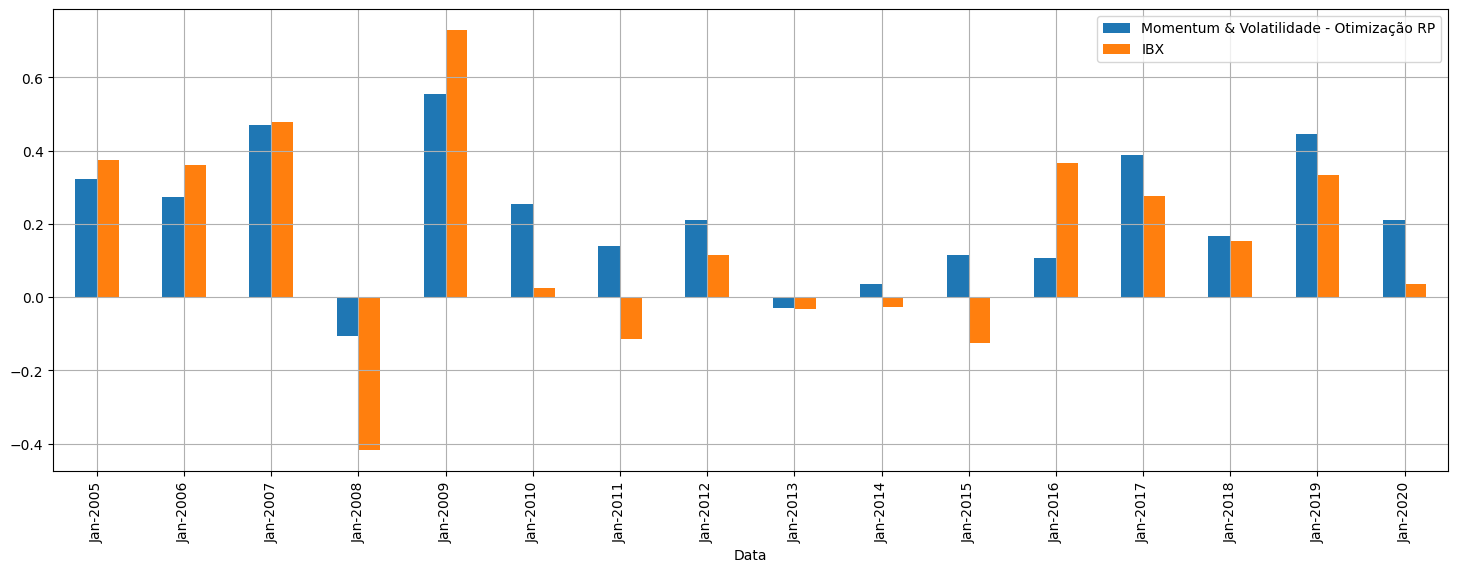

In [701]:
# Retorno anual de um portfólio otimizado comparado à referência IBX
df2 = pd.DataFrame(columns=['Data', 'Momentum & Volatilidade - Otimização RP', 'IBX'])
for ind in range(0, len(df.index) - 12, 12):
    tempo = df.iloc[ind+12] / df.iloc[ind] - 1
    df2 = df2._append(tempo, ignore_index=True)
    df2.iat[len(df2) - 1, 0] = df.index[ind]
df2.set_index(keys='Data', inplace=True)
df2.plot.bar(figsize=(18,6), grid=True);

> Esse portifólio foi mais rentável, superou o IBX em 11 períodos considerando altas e baixas, o que representa 68.7% do período.

##**Passo 2.3: Portifólio otimizado com Foco em Rentabilidade - Volumes iguais de parâmetros**

>Com o objetivo de testar diferentes fatores e alterar a quantidade de ativos alocados sobre cada fator, foi desenvolvido o seguinte teste com dados passados:

>O resultado encontrado foi que os fatores Momentum e Volatilidade tenham tido os melhores desempenhos individuais para 30 ações, vamos testar o portifólio com os dois juntos para essa mesma quantidade(30) de ações, e foi visto que quando em iguais proporções de ações com esses fatores juntos, o resultado não é ótimo, entretanto, quando se usa quantidade diferentes de ações para cada fator o resultado é satisfatório:

In [702]:


# Composição do portifólio:
profit_port2 = sel_2factors_port(data_factors['ROIC'], 30, data_factors['Momentum'], 30)

# Otimização do portifólio:
optimized_rent_port2 = sel_optimized_port(profit_port2, 'MDP', market_data['Fechamento'])
dados_port = eval_port(optimized_rent_port2, market_data['Fechamento'])
beta, alpha = np.polyfit(data_index['IBX']['variacoes'], dados_port['variacoes'], 1)
actives, _ = get_actives_value(optimized_rent_port2, start_date, end_date, 1)

table.clear()
table.field_names = ["Fatores Qualidade e Momentum - MDP", "Retorno Acumulado", "Retorno Anualizado",
                      "Volatilidade Anualizada", "Relação Retorno/Volatilidade",
                      "Draw Down", "Alfa", "Beta"]

table.add_row([
    'Dados',
    f'{round(dados_port["ret_acumulados"][-1] * 100 - 100, 2)}%',
    f'{round(dados_port["ret_anualizado"] * 100, 2)}%',
    f'{round(dados_port["vol_anualizada"] * 100, 2)}%',
    round(dados_port["ret_anualizado"] / dados_port["vol_anualizada"], 2),
    f'{round(np.min(dados_port["drawdowns"]) * 100, 2)}%',
    f'{round(alpha * (12 / eval_steps) * 100, 2)}%',
    round(beta, 2),
])

print(table)

+------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+
| Fatores Qualidade E Momentum - Mdp | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa  | Beta |
+------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+
|               Dados                |      1690.04%     |       19.76%       |          23.1%          |             0.86             |  -43.41%  | 10.81% | 0.7  |
+------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+


### **Passo 2.3.1**: Portifólio otimizado com Foco em Rentabilidade - Variando quantidade parâmetros

>Objetivando testar diferentes fatores e alterar a quantidade de ativos alocados sobre cada fator, foi desenvolvido o seguinte teste com dados passados:


> O resultado encontrado foi que os fatores Momentum e Volatilidade tenham tido os melhores desempenhos individuais para 30 ações, os fatores Momentum e Qualidade com 36 e 26 ações, respectivamente, obtiveram um desempenho consideravelmente melhor para a rentabilidade quando otimizado pelo método MDP em relação as métodos GMV e RP:

In [703]:
# Composição do portifólio:
profit_port2 = sel_2factors_port(data_factors['ROIC'], 36, data_factors['Momentum'], 26)

# Otimização do portifólio:
optimized_rent_port2 = sel_optimized_port(profit_port2, 'MDP', market_data['Fechamento'])
dados_port = eval_port(optimized_rent_port2, market_data['Fechamento'])
beta, alpha = np.polyfit(data_index['IBX']['variacoes'], dados_port['variacoes'], 1)
actives, _ = get_actives_value(optimized_rent_port2, start_date, end_date, 1)

table.clear()
table.field_names = ["Fatores Qualidade e Momentum - MDP", "Retorno Acumulado", "Retorno Anualizado",
                      "Volatilidade Anualizada", "Relação Retorno/Volatilidade",
                      "Draw Down", "Alfa", "Beta"]

table.add_row([
    'Dados',
    f'{round(dados_port["ret_acumulados"][-1] * 100 - 100, 2)}%',
    f'{round(dados_port["ret_anualizado"] * 100, 2)}%',
    f'{round(dados_port["vol_anualizada"] * 100, 2)}%',
    round(dados_port["ret_anualizado"] / dados_port["vol_anualizada"], 2),
    f'{round(np.min(dados_port["drawdowns"]) * 100, 2)}%',
    f'{round(alpha * (12 / eval_steps) * 100, 2)}%',
    round(beta, 2)
])

print(table)

+------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
| Fatores Qualidade E Momentum - Mdp | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa | Beta |
+------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
|               Dados                |      3996.05%     |       26.12%       |          23.28%         |             1.12             |  -46.25%  | 16.1% | 0.7  |
+------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+


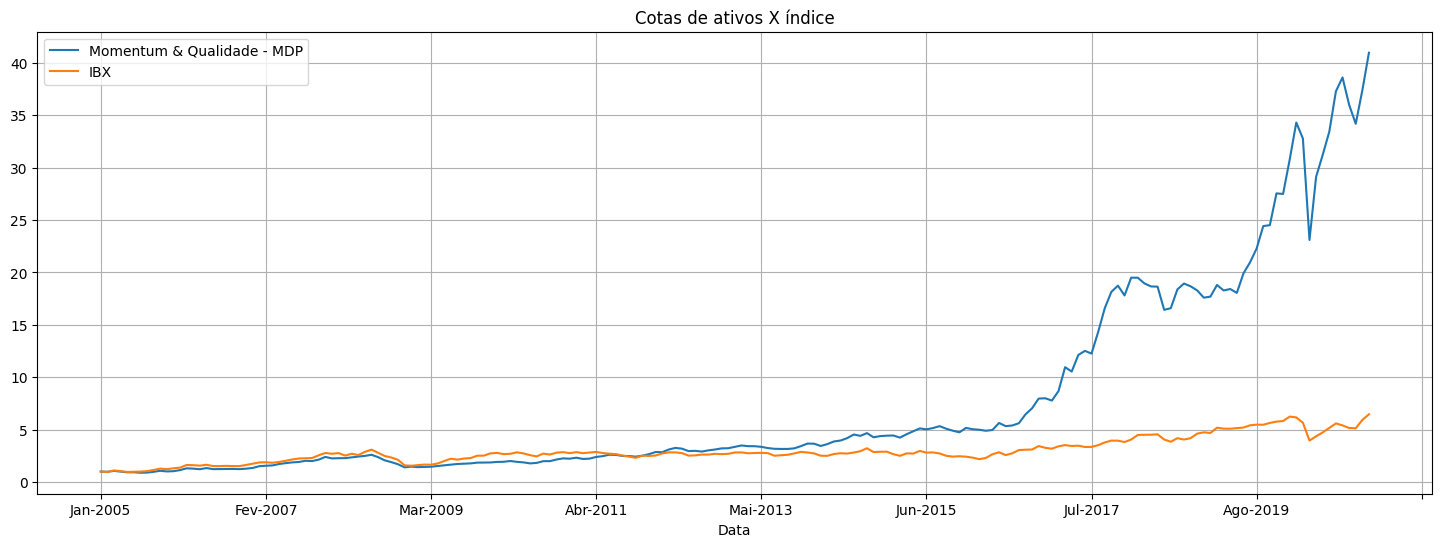

In [704]:
# Evolução das cotas do portifólio otimizado comparadas com o índice de referência IBX:
df = pd.DataFrame(index=data_factors['ROIC'].iloc[start_date:end_date+1].index)
df['Momentum & Qualidade - MDP'] = dados_port['ret_acumulados']
df['IBX'] = data_index['IBX']['ret_acumulados']
df.iloc[0:].plot(figsize=(18,6), grid=True, title='Cotas de ativos X índice');

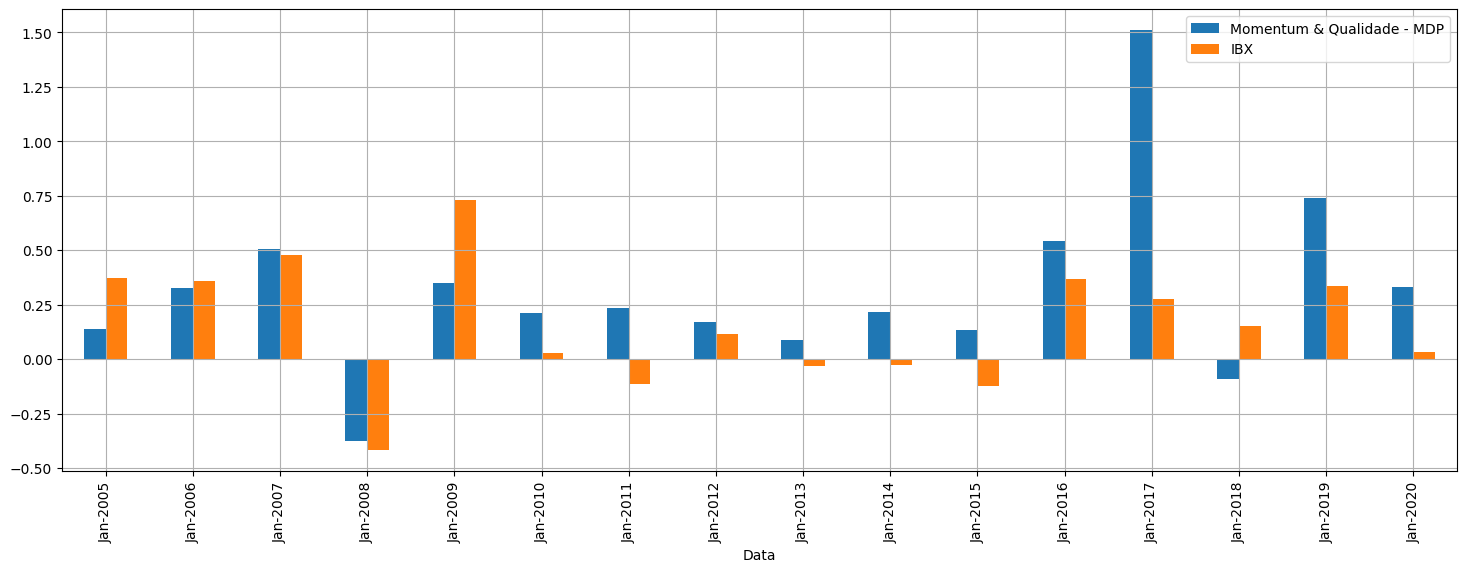

In [705]:
# Retorno anual de um portfólio otimizado comparado à referência IBX
df2 = pd.DataFrame(columns=['Data', 'Momentum & Qualidade - MDP', 'IBX'])
for ind in range(0, len(df.index) - 12, 12):
    tempo = df.iloc[ind+12] / df.iloc[ind] - 1
    df2 = df2._append(tempo, ignore_index=True)
    df2.iat[len(df2) - 1, 0] = df.index[ind]
df2.set_index(keys='Data', inplace=True)
df2.plot.bar(figsize=(18,6), grid=True);

>Considerando todo o período, esse portifólio superou IBX em 75% do tempo, que corresponde a 12 períodos.

### **Passo 2.4: Portifólio com foco em volatilidade - Mesmo volume de parâmetros**

> Para compor o portifólio, com foco em menor volatilidade, menos arrojado, podemos se embasar na mesma estratégia de considerar a análise dos 30 melhores ativos por fator e usar os 2 fatores que apresentaram melhor desempenho individual na volatilidade: Volatilidade e Qualidade.

In [706]:
vol_port = sel_2factors_port(data_factors['Vol'], 30, data_factors['ROIC'], 30)
data_port = eval_port(vol_port, market_data['Fechamento'])
beta, alpha = np.polyfit(data_index['IBX']['variacoes'], data_port['variacoes'], 1)
actives, _ = get_actives_value(vol_port, start_date, end_date, 1)

table.clear()
table.field_names = ["Fatores Volatilidade e Qualidade", "Retorno Acumulado", "Retorno Anualizado",
                      "Volatilidade Anualizada", "Relação Retorno/Volatilidade",
                      "Draw Down", "Alfa", "Beta"]

table.add_row([
    'Dados',
    f'{round(data_port["ret_acumulados"][-1] * 100 - 100, 2)}%',
    f'{round(data_port["ret_anualizado"] * 100, 2)}%',
    f'{round(data_port["vol_anualizada"] * 100, 2)}%',
    round(data_port["ret_anualizado"] / data_port["vol_anualizada"], 2),
    f'{round(np.min(data_port["drawdowns"]) * 100, 2)}%',
    f'{round(alpha * (12 / eval_steps) * 100, 2)}%',
    round(beta, 2),
])

print(table)

+----------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
| Fatores Volatilidade E Qualidade | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa | Beta |
+----------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
|              Dados               |      991.27%      |       16.11%       |          16.8%          |             0.96             |  -32.19%  | 7.76% | 0.61 |
+----------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+


##**Passo 2.4.1: Portifólio com foco em volatilidade - Variando parâmetros**

>Para compor o portifólio, com foco em menor volatilidade, menos arrojado, podemos usar os 2 fatores que apresentaram melhor desempenho individual na volatilidade: Volatilidade e Qualidade e foi encontrado a menor volatilidade usando, respectivamente, 30 e 35 ativos.

In [707]:
vol_port = sel_2factors_port(data_factors['Vol'], 30, data_factors['ROIC'], 35)
data_port = eval_port(vol_port, market_data['Fechamento'])
beta, alpha = np.polyfit(data_index['IBX']['variacoes'], data_port['variacoes'], 1)
actives, _ = get_actives_value(vol_port, start_date, end_date, 1)

table.clear()
table.field_names = ["Fatores Volatilidade e Qualidade", "Retorno Acumulado", "Retorno Anualizado",
                      "Volatilidade Anualizada", "Relação Retorno/Volatilidade",
                      "Draw Down", "Alfa", "Beta"]

table.add_row([
    'Dados',
    f'{round(data_port["ret_acumulados"][-1] * 100 - 100, 2)}%',
    f'{round(data_port["ret_anualizado"] * 100, 2)}%',
    f'{round(data_port["vol_anualizada"] * 100, 2)}%',
    round(data_port["ret_anualizado"] / data_port["vol_anualizada"], 2),
    f'{round(np.min(data_port["drawdowns"]) * 100, 2)}%',
    f'{round(alpha * (12 / eval_steps) * 100, 2)}%',
    round(beta, 2),
])

print(table)

+----------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
| Fatores Volatilidade E Qualidade | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa | Beta |
+----------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
|              Dados               |      949.98%      |       15.83%       |          16.51%         |             0.96             |  -29.82%  | 7.57% | 0.6  |
+----------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+


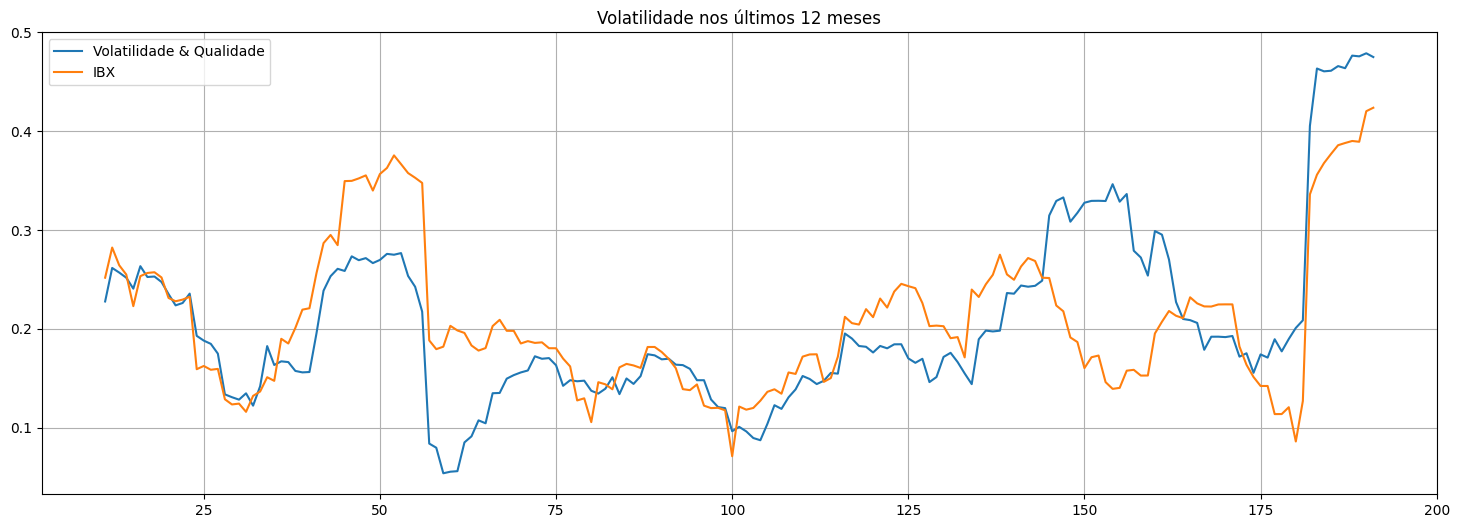

In [708]:
# Evolução da volatilidade dos últimos 12 meses de cada portfólio comparadas com o índice de referência IBX:
df = pd.DataFrame()
df['Volatilidade & Qualidade'] = pd \
    .Series(dados_port['variacoes']) \
    .rolling(int(12 / eval_steps)) \
    .std() * (sqrt(int(12 / eval_steps)))
df['IBX'] = pd \
    .Series(data_index['IBX']['variacoes']) \
    .rolling(int(12 / eval_steps)) \
    .std()*(sqrt(int(12 / eval_steps)))
df.plot(figsize=(18,6), grid=True, title='Volatilidade nos últimos 12 meses');

>Percebe-se no resultado, a volatilidade é significativamente menor em relação ao índice IBX.

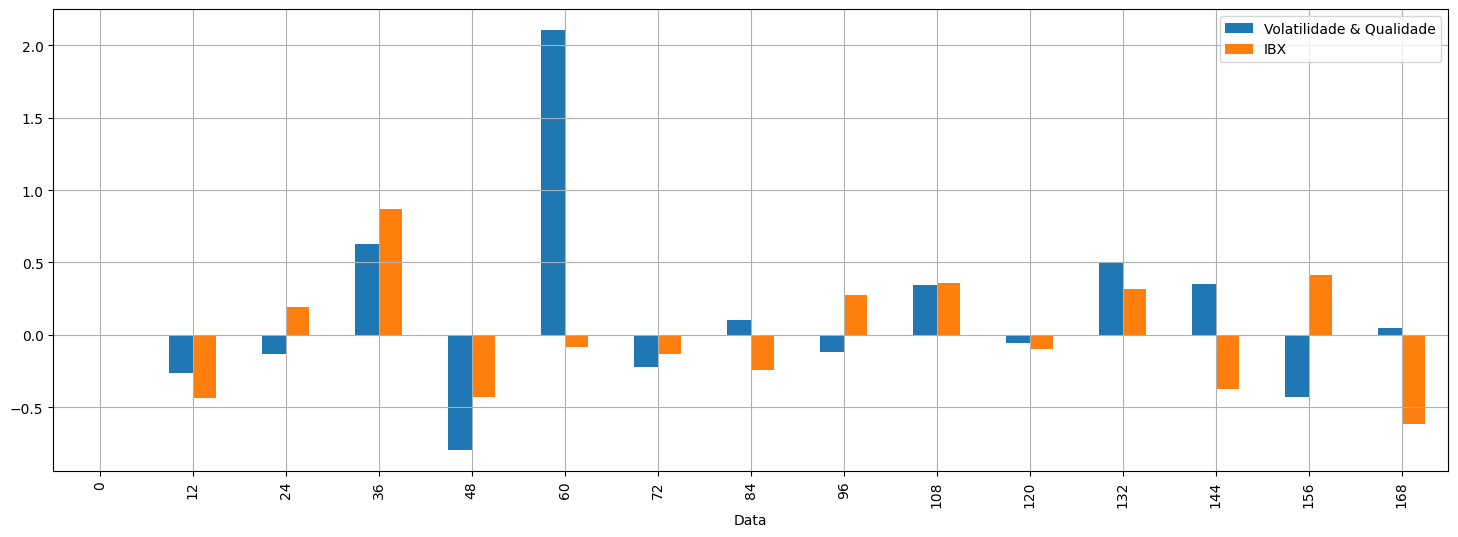

In [709]:
# Retorno anual de um portfólio comparado à referência IBX
df2 = pd.DataFrame(columns=['Data', 'Volatilidade & Qualidade', 'IBX'])
for ind in range(0, len(df.index) - 12, 12):
    tempo = df.iloc[ind+12] / df.iloc[ind] - 1
    df2 = df2._append(tempo, ignore_index=True)
    df2.iat[len(df2) - 1, 0] = df.index[ind]
df2.set_index(keys='Data', inplace=True)
df2.plot.bar(figsize=(18,6), grid=True);

### **Passo 2.5**: Portifólio otimizado com foco em volatilidade

>Otimizando o portifólio com os métodos do riskfolio, obtemos:

In [710]:

table.clear()
table.field_names = ["Fatores Volatilidade e Qualidade - Otimização", "Retorno Acumulado", "Retorno Anualizado",
                      "Volatilidade Anualizada", "Relação Retorno/Volatilidade",
                      "Draw Down", "Alfa", "Beta"]

for label in ['RP', 'GMV', 'MDP']:
    optimized_vol_port = sel_optimized_port(vol_port, label, market_data['Fechamento'])
    port_data = eval_port(optimized_vol_port, market_data['Fechamento'])
    beta, alpha = np.polyfit(data_index['IBX']['variacoes'], port_data['variacoes'], 1)
    actives, _ = get_actives_value(optimized_vol_port, start_date, end_date, 1)

    table.add_row([
    f'Otimização {label}',
    f'{round(port_data["ret_acumulados"][-1] * 100 - 100, 2)}%',
    f'{round(port_data["ret_anualizado"] * 100, 2)}%',
    f'{round(port_data["vol_anualizada"] * 100, 2)}%',
    round(port_data["ret_anualizado"] / port_data["vol_anualizada"], 2),
    f'{round(np.min(port_data["drawdowns"]) * 100, 2)}%',
    f'{round(alpha * (12 / eval_steps) * 100, 2)}%',
    round(beta, 2),
])

print(table)

+-----------------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
| Fatores Volatilidade E Qualidade - Otimização | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa | Beta |
+-----------------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
|                 Otimização RP                 |      945.88%      |       15.8%        |          16.04%         |             0.99             |  -28.55%  | 7.89% | 0.57 |
|                 Otimização GMV                |       822.7%      |       14.9%        |          15.55%         |             0.96             |  -20.48%  | 8.23% | 0.48 |
|                 Otimização MDP                |      988.74%      |       16.09%       |          17.07%         |         

>A otimização reduziu um pouco mais a volatilidade para o método GMV, e como pode-se ver abaixo com

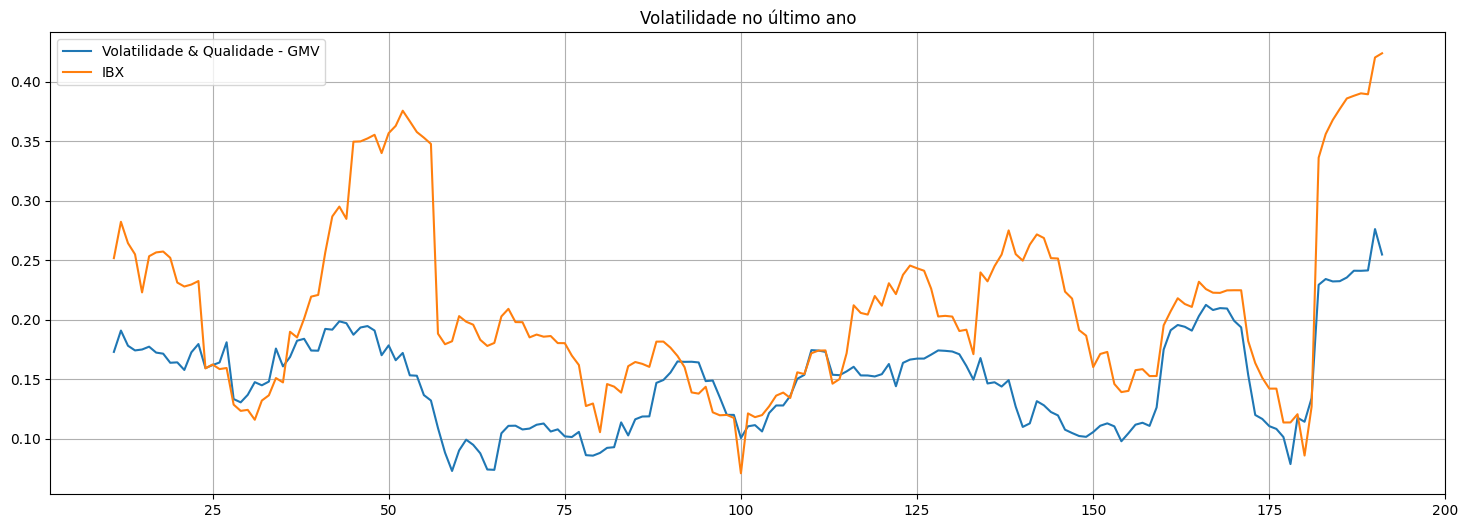

In [711]:
gmv_port = sel_optimized_port(vol_port, 'GMV', market_data['Fechamento'])
data_port = eval_port(gmv_port, market_data['Fechamento'])

# Evolução da volatilidade dos últimos 12 meses de cada portfólio otimizado com GMV comparada com o índice de referência IBX:
df = pd.DataFrame()
df['Volatilidade & Qualidade - GMV'] = pd \
    .Series(data_port['variacoes']) \
    .rolling(int(12 / eval_steps)) \
    .std() * (sqrt(int(12 / eval_steps)))
df['IBX'] = pd \
    .Series(data_index['IBX']['variacoes']) \
    .rolling(int(12 / eval_steps)) \
    .std()*(sqrt(int(12 / eval_steps)))
df.plot(figsize=(18,6), grid=True, title='Volatilidade no último ano');

In [712]:
actives, _ = get_actives_value(gmv_port, start_date, end_date, 1)
display(actives)

['ABEV3',
 'CRFB3',
 'CPFE3',
 'EGIE3',
 'FLRY3',
 'HAPV3',
 'HYPE3',
 'ITSA4',
 'JBSS3',
 'MDIA3',
 'PSSA3',
 'SAPR11',
 'TAEE11',
 'TRPL4']

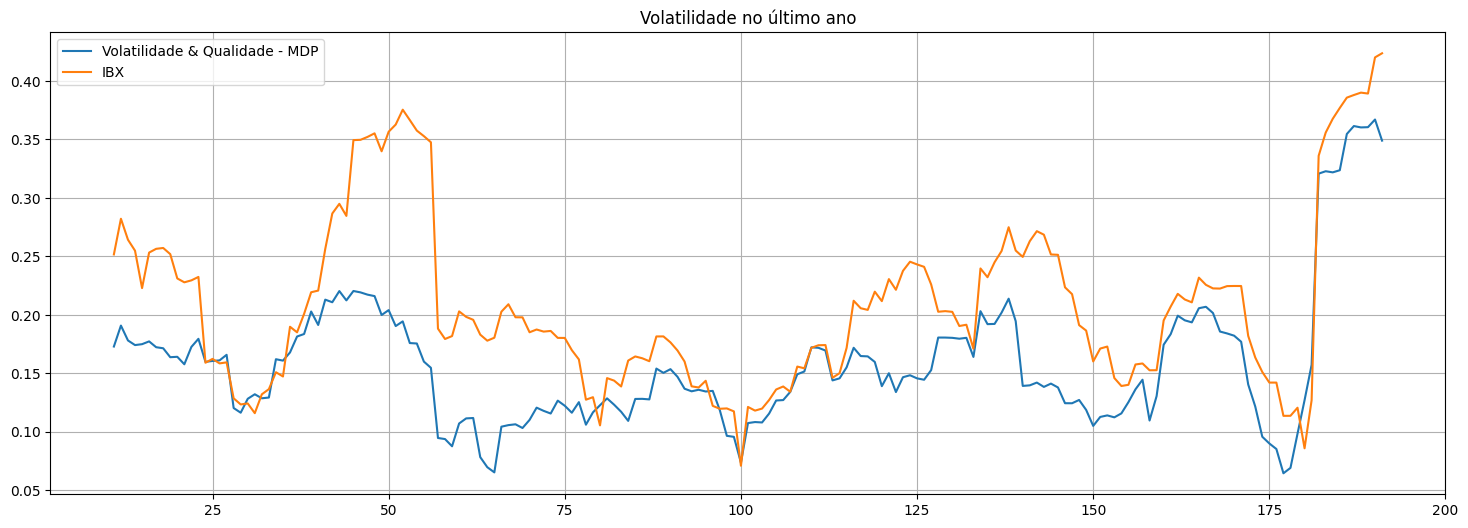

In [713]:
mdp_port = sel_optimized_port(vol_port, 'MDP', market_data['Fechamento'])
data_port = eval_port(mdp_port, market_data['Fechamento'])

# Evolução da volatilidade dos últimos 12 meses de cada portfólio comparadas com o índice de referência IBX:
df2 = pd.DataFrame()
df2['Volatilidade & Qualidade - MDP'] = pd \
    .Series(data_port['variacoes']) \
    .rolling(int(12 / eval_steps)) \
    .std() * (sqrt(int(12 / eval_steps)))
df2['IBX'] = pd \
    .Series(data_index['IBX']['variacoes']) \
    .rolling(int(12 / eval_steps)) \
    .std()*(sqrt(int(12 / eval_steps)))
df2.plot(figsize=(18,6), grid=True, title='Volatilidade no último ano');

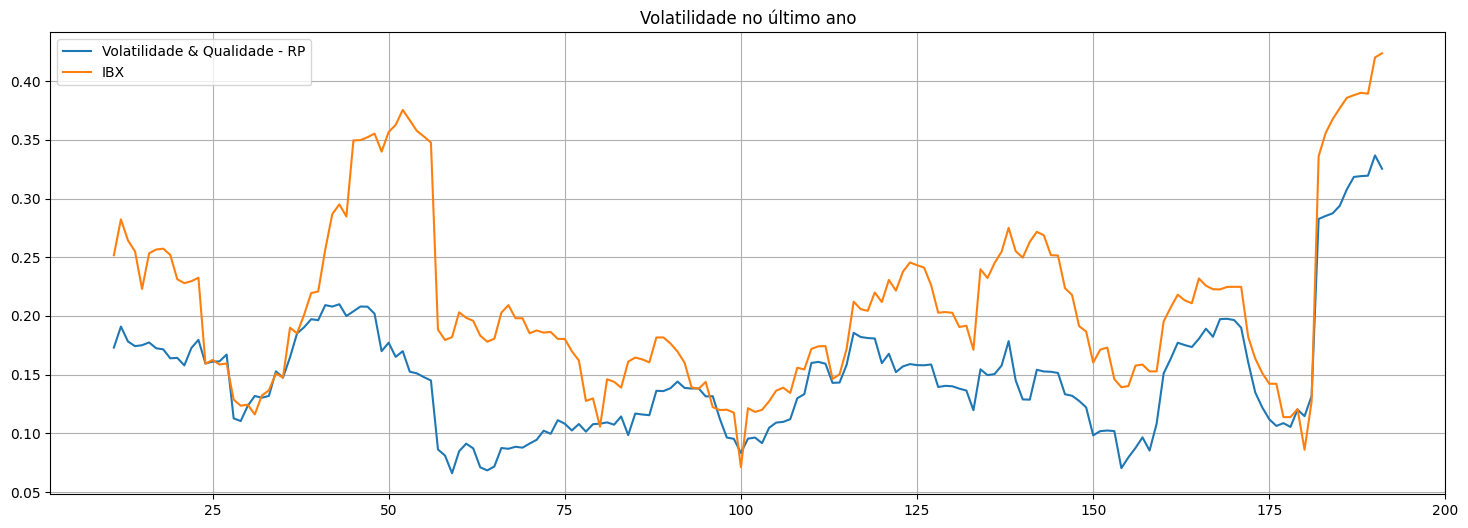

In [714]:
rp_port = sel_optimized_port(vol_port, 'RP', market_data['Fechamento'])
data_port = eval_port(rp_port, market_data['Fechamento'])

# Evolução da volatilidade dos últimos 12 meses de cada portfólio comparadas com o índice de referência IBX:
df3 = pd.DataFrame()
df3['Volatilidade & Qualidade - RP'] = pd \
    .Series(data_port['variacoes']) \
    .rolling(int(12 / eval_steps)) \
    .std() * (sqrt(int(12 / eval_steps)))
df3['IBX'] = pd \
    .Series(data_index['IBX']['variacoes']) \
    .rolling(int(12 / eval_steps)) \
    .std()*(sqrt(int(12 / eval_steps)))
df3.plot(figsize=(18,6), grid=True, title='Volatilidade no último ano');

##**Conclusão**

>Graças aos ensinametos transmitidos em aula e pelo presente trabalho, foi possível explorar o conceito e as práticas do *factor investing*. Ao invés de analisar ações específicas e fazer considerações individuais, e de certa maneira enviesadas, sujeitas aos viéses intrínsecos do ser humano, é possível montar um portfólio tendo como guia esses fatores características quantificáveis, que se relacionam com o desempenho do ativo.

>Empregamos para seleção das ações uma função de ranking simples para cada um dos fatores, seguida da escolha de uma interseção das melhores ações entre os fatores para compor nosso portifólio, onde foi possível obter resultados expressivos. Além disso, também foi possível explorar otimização de portfólio de três maneiras distintas:GMV, MDP e RP.

>De modo geral, vimos como uma carteira pode ser montada ao se combinar fatores(valor, qualidade, volatilidade, momentum, tamanho da empresa) e que é possível superar o mercado através dessas combinações não triviais de ativos, apenas ilustrando a vasta quantidade de opções possíveis por meio da abordagem de investimento em fatores.

```
Maior retorno - com volume de ações igual para cada um dos fatores:

+---------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+
| Fatores Momentum E Volatilidade | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa  | Beta |
+---------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+
|              Dados              |      2422.46%     |       22.35%       |          19.0%          |             1.18             |  -30.97%  | 13.39% | 0.61 |
+---------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+

Maior retorno - com volume de ações diferente para cada um dos fatores:

+------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
| Fatores Qualidade E Momentum - Mdp | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa | Beta |
+------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
|               Dados                |      3996.05%     |       26.12%       |          23.28%         |             1.12             |  -46.25%  | 16.1% | 0.7  |
+------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+

Maior retorno(com riskfolio) - RP performou melhor:

+--------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Tipo De Otimização | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa  | Beta |                                                                                                                          Ações                                                                                                                          |
+--------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   Otimização RP    |      1995.32%     |       20.94%       |          18.66%         |             1.12             |   -33.4%  | 12.61% | 0.58 ||
|   Otimização GMV   |      1201.98%     |       17.4%        |          19.1%          |             0.91             |  -33.47%  | 10.37% | 0.53 ||
|   Otimização MDP   |      1367.04%     |       18.28%       |          19.05%         |             0.96             |  -33.16%  | 10.83% | 0.55 |
+--------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+

Menor volatilidade - Com volumes iguais e ações para cada um dos fatores:

+----------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
| Fatores Volatilidade E Qualidade | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa | Beta |
+----------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
|              Dados               |      991.27%      |       16.11%       |          16.8%          |             0.96             |  -32.19%  | 7.76% | 0.61 |
+----------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+

Menor volatilidade - diferentes volumes de ações para cada um dos fatores:

+----------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
| Fatores Volatilidade E Qualidade | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa | Beta |
+----------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
|              Dados               |      949.98%      |       15.83%       |          16.51%         |             0.96             |  -29.82%  | 7.57% | 0.6  |
+----------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+

Menor volatilidade(com riskfolio) - GMV foi mais eficiente:

+-----------------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
| Fatores Volatilidade E Qualidade - Otimização | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa | Beta |
+-----------------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
|                 Otimização RP                 |      945.88%      |       15.8%        |          16.04%         |             0.99             |  -28.55%  | 7.89% | 0.57 |
|                 Otimização GMV                |       822.7%      |       14.9%        |          15.55%         |             0.96             |  -20.48%  | 8.23% | 0.48 |
|                 Otimização MDP                |      988.74%      |       16.09%       |          17.07%         |             0.94             |  -35.34%  | 8.25% | 0.57 |
+-----------------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
```

Importante ressaltar que o primeiro resultado é inversamente proporcional ao número de ações, pois tentando um portifólio com 60 ações para cada fator, tivemos:

```
+---------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
| Fatores Momentum E Volatilidade | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa | Beta |
+---------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
|              Dados              |      993.01%      |       16.12%       |          18.78%         |             0.86             |  -39.17%  | 6.01% | 0.76 |
+---------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+-------+------+
```

Também é notório que quando utilizamos volumes semelhantes de ações para compor um portifólio de 2 fatores, mesmo que otimizadoo, o resultado não é o almejado:

```
+------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+
| Fatores Qualidade E Momentum - Mdp | Retorno Acumulado | Retorno Anualizado | Volatilidade Anualizada | Relação Retorno/Volatilidade | Draw Down |  Alfa  | Beta |
+------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+
|               Dados                |      1690.04%     |       19.76%       |          23.1%          |             0.86             |  -43.41%  | 10.81% | 0.7  |
+------------------------------------+-------------------+--------------------+-------------------------+------------------------------+-----------+--------+------+
```